In [ ]:
pip install pydicom

In [ ]:
import pydicom as dicom
import zipfile
from io import StringIO
from PIL import Image
import imghdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
import cv2
from PIL import Image
from tensorflow.keras.applications.mobilenet import MobileNet
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
# specify your image path
#read train images 
dir_name = r"/content/drive/MyDrive/stage_2_train_images"


df_dicom_data_train = pd.DataFrame(columns = ['Pixel Data','Patient Name','patientId','Patient Sex','Patient Age',
                                             'Body Part Examined','View Position'])

count = 0
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
for subdir, dirs, files in os.walk(dir_name):
    print(len(files))
    for file in files:
        count = count + 1
        file_path = os.path.join(subdir, file)
        
        ds = dicom.dcmread(file_path)
        
        img = cv2.resize(ds.pixel_array, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
        df_dicom_data_train = df_dicom_data_train.append({'Pixel Data':img,'Patient Name':ds.PatientName ,'patientId':ds.PatientID,
                                                            'Patient Sex':ds.PatientSex,'Patient Age':ds.PatientAge,
                                                            'Body Part Examined':ds.BodyPartExamined  ,'View Position':ds.ViewPosition},ignore_index=True)
        
        


26684


In [ ]:
df_dicom_data_trainDF = df_dicom_data_train[df_dicom_data_train.duplicated(['patientId'])]
df_dicom_data_trainDF.shape
#There are no duplicates patient id entries in the dycom records

(0, 7)

In [ ]:
#Read class info
dir_name = r"/content/drive/MyDrive/stage_2_detailed_class_info.csv"

df_class_info = pd.read_csv(dir_name)
df_class_info.head(5)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [ ]:
df_class_infoDF = df_class_info[df_class_info.duplicated()]
df_class_infoDF.shape
#There are 3543 duplicates rows in class information hence those can be deleted

(3543, 2)

In [ ]:
#Read train labels 
dir_name = r"/content/drive/MyDrive/stage_2_train_labels.csv"

df_train_labels = pd.read_csv(dir_name)
df_train_labels.head(5)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [ ]:
df_train_labelsDF = df_train_labels[df_train_labels.duplicated()]
df_train_labelsDF.shape
#There are no duplicates rows in the labels

(0, 6)

In [ ]:
df_train_labelsDF = df_train_labels[df_train_labels.duplicated('patientId')]
print(df_train_labelsDF.shape)
df_train_labels.sort_values(by=['patientId'])
#There are 3543 duplicates patient id rows in the labels which means one patient has had many X-rays done with different bounding box values as shown below
#However, since bonding box values are different so we can keep them as training data

(3543, 6)


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
28989,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0
28990,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1
28991,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1
28992,000fe35a-2649-43d4-b027-e67796d412e0,570.0,282.0,269.0,409.0,1
...,...,...,...,...,...,...
28984,fffb2395-8edd-4954-8a89-ffe2fd329be3,641.0,473.0,201.0,309.0,1
28985,fffba05a-1635-4545-9bbd-57ad4cfe8d27,NaN,NaN,NaN,NaN,0
28986,fffc95b5-605b-4226-80ab-62caec682b22,NaN,NaN,NaN,NaN,0
28987,fffcff11-d018-4414-971a-a7cefa327795,NaN,NaN,NaN,NaN,0


In [ ]:
print('Training Label Shape &','Class Info Shape',df_train_labels.shape,df_class_info.shape)

Training Label Shape & Class Info Shape (30227, 6) (30227, 2)


In [ ]:
#Find count of patient ids common in training labels and class info
len(pd.Series(df_train_labels.patientId.isin(df_class_info.patientId).values.astype(int), df_train_labels.patientId.values))

30227

In [ ]:
#Find count of patient ids common in training labels and class info
len(pd.Series(df_class_info.patientId.isin(df_train_labels.patientId).values.astype(int), df_class_info.patientId.values))

30227

In [ ]:
ctab1 = pd.crosstab(df_class_info.patientId,df_class_info['class'])
ctab1

class,Lung Opacity,No Lung Opacity / Not Normal,Normal
patientId,,,
0004cfab-14fd-4e49-80ba-63a80b6bddd6,0,1,0
000924cf-0f8d-42bd-9158-1af53881a557,0,0,1
000db696-cf54-4385-b10b-6b16fbb3f985,2,0,0
000fe35a-2649-43d4-b027-e67796d412e0,2,0,0
001031d9-f904-4a23-b3e5-2c088acd19c6,2,0,0
...,...,...,...
fffb2395-8edd-4954-8a89-ffe2fd329be3,2,0,0
fffba05a-1635-4545-9bbd-57ad4cfe8d27,0,0,1
fffc95b5-605b-4226-80ab-62caec682b22,0,1,0


In [ ]:

#Create new column to indicate if any patient has multi class entries
ctab1['Multiple_Class'] = ctab1.apply(lambda row: True if ((row['Lung Opacity'] > 0 and row['No Lung Opacity / Not Normal'] > 0) or 
                                                           (row['Normal'] > 0 and row['No Lung Opacity / Not Normal'] > 0) or 
                                                           (row['Normal'] > 0 and row['Lung Opacity'] > 0)) else False,axis=1)


ctab1[ctab1['Multiple_Class']==True]

#No multi class entry present for any patient

class,Lung Opacity,No Lung Opacity / Not Normal,Normal,Multiple_Class
patientId,,,,


In [ ]:
ctab2 = pd.crosstab(df_train_labels.patientId,df_train_labels['Target'])
ctab2


Target,0,1
patientId,,
0004cfab-14fd-4e49-80ba-63a80b6bddd6,1,0
000924cf-0f8d-42bd-9158-1af53881a557,1,0
000db696-cf54-4385-b10b-6b16fbb3f985,0,2
000fe35a-2649-43d4-b027-e67796d412e0,0,2
001031d9-f904-4a23-b3e5-2c088acd19c6,0,2
...,...,...
fffb2395-8edd-4954-8a89-ffe2fd329be3,0,2
fffba05a-1635-4545-9bbd-57ad4cfe8d27,1,0
fffc95b5-605b-4226-80ab-62caec682b22,1,0


In [ ]:
ctab2

Target,0,1
patientId,,
0004cfab-14fd-4e49-80ba-63a80b6bddd6,1,0
000924cf-0f8d-42bd-9158-1af53881a557,1,0
000db696-cf54-4385-b10b-6b16fbb3f985,0,2
000fe35a-2649-43d4-b027-e67796d412e0,0,2
001031d9-f904-4a23-b3e5-2c088acd19c6,0,2
...,...,...
fffb2395-8edd-4954-8a89-ffe2fd329be3,0,2
fffba05a-1635-4545-9bbd-57ad4cfe8d27,1,0
fffc95b5-605b-4226-80ab-62caec682b22,1,0


In [ ]:

#Create new column to indicate if any patient has multiple values for target
ctab2['Multiple_Target'] = ctab2.apply(lambda row: True if (row[0] > 0 and row[1] > 0) else False,axis=1)


ctab2[ctab2['Multiple_Target']==True]

#No multi target entry present for any patient

Target,0,1,Multiple_Target
patientId,,,


In [ ]:
df_train_labels_class = pd.merge(df_train_labels , df_class_info,on='patientId' )


In [ ]:
df_train_labels_class

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
...,...,...,...,...,...,...,...
37624,c1f6b555-2eb1-4231-98f6-50a963976431,NaN,NaN,NaN,NaN,0,Normal
37625,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity
37626,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1,Lung Opacity
37627,c1f7889a-9ea9-4acb-b64c-b737c929599a,233.0,424.0,201.0,356.0,1,Lung Opacity


In [ ]:
x1=df_train_labels_class[df_train_labels_class['Target']==1]['x'].isna()
print(x1.value_counts())

x1=df_train_labels_class[df_train_labels_class['Target']==0]['x'].isna()
print(x1.value_counts())

#There are no entries where target =1 and bounding box is not present. Vice versa, there are no entries where target = 0 and bounding box is present

False    16957
Name: x, dtype: int64
True    20672
Name: x, dtype: int64


In [ ]:
df_train_labels_class[df_train_labels_class['Target']==1]['class'].value_counts()
#Only class 'Lung Opacity' has target value as 1

Lung Opacity    16957
Name: class, dtype: int64

In [ ]:
df_dicom_data_train.head(5)

,Pixel Data,Patient Name,patientId,Patient Sex,Patient Age,Body Part Examined,View Position
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(f, 7, 9, e, 5, a, 7, 5, -, 5, e, 1, 5, -, 4, ...",f79e5a75-5e15-431a-9ba3-de64c1724b65,M,59,CHEST,PA
1,"[[12, 11, 12, 12, 12, 12, 12, 11, 11, 11, 11, ...","(f, 7, 9, f, a, 9, 4, e, -, 8, 8, 8, 6, -, 4, ...",f79fa94e-8886-425c-95d4-81abfea92aee,F,43,CHEST,PA
2,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","(f, 7, 9, f, c, 7, 5, 9, -, f, d, e, 0, -, 4, ...",f79fc759-fde0-4e2e-8951-26ac8af5ef89,F,45,CHEST,AP
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(f, 7, a, 1, 6, 9, e, 2, -, a, 1, a, 7, -, 4, ...",f7a169e2-a1a7-439a-ab83-0d34cf5ae4b9,M,52,CHEST,PA
4,"[[6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,...","(f, 7, a, 1, 7, 2, f, c, -, a, 3, 4, f, -, 4, ...",f7a172fc-a34f-4155-806d-7b0afe2a6156,M,26,CHEST,AP


In [ ]:
#Merge dicom data with labels and class data

df_data = pd.merge(df_dicom_data_train,df_train_labels_class,how='left',on='patientId')

In [ ]:
df_data['View Position'].value_counts()

AP    21817
PA    15812
Name: View Position, dtype: int64

In [ ]:
df_data['Body Part Examined'].value_counts()

CHEST    37629
Name: Body Part Examined, dtype: int64

In [ ]:
df_data.head(5)

,Pixel Data,Patient Name,patientId,Patient Sex,Patient Age,Body Part Examined,View Position,x,y,width,height,Target,class
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","(f, 7, 9, e, 5, a, 7, 5, -, 5, e, 1, 5, -, 4, ...",f79e5a75-5e15-431a-9ba3-de64c1724b65,M,59,CHEST,PA,NaN,NaN,NaN,NaN,0,Normal
1,"[[12, 11, 12, 12, 12, 12, 12, 11, 11, 11, 11, ...","(f, 7, 9, f, a, 9, 4, e, -, 8, 8, 8, 6, -, 4, ...",f79fa94e-8886-425c-95d4-81abfea92aee,F,43,CHEST,PA,NaN,NaN,NaN,NaN,0,Normal
2,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","(f, 7, 9, f, c, 7, 5, 9, -, f, d, e, 0, -, 4, ...",f79fc759-fde0-4e2e-8951-26ac8af5ef89,F,45,CHEST,AP,613.0,241.0,169.0,479.0,1,Lung Opacity
3,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","(f, 7, 9, f, c, 7, 5, 9, -, f, d, e, 0, -, 4, ...",f79fc759-fde0-4e2e-8951-26ac8af5ef89,F,45,CHEST,AP,613.0,241.0,169.0,479.0,1,Lung Opacity
4,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","(f, 7, 9, f, c, 7, 5, 9, -, f, d, e, 0, -, 4, ...",f79fc759-fde0-4e2e-8951-26ac8af5ef89,F,45,CHEST,AP,276.0,248.0,168.0,477.0,1,Lung Opacity


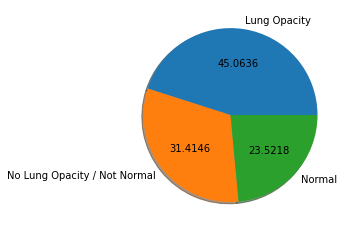

In [ ]:
#Get class distribution
v_counts = df_data['class'].value_counts()
plt.pie(v_counts, labels=v_counts.index, autopct='%.4f', shadow=True);
plt.show()

#Data is fairly balanced with 45% pneumonia cases and 55% non-pneumonia cases

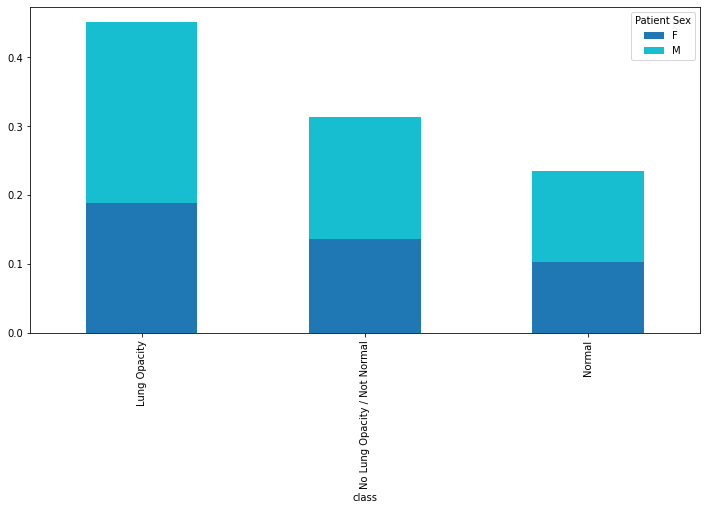

In [ ]:
cross_tab = pd.crosstab(index=df_data['class'],
                        columns=df_data['Patient Sex'],normalize=True)
cross_tab.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(12, 6))
plt.show()
#All class seem to have slightly higher male distribution compared to females

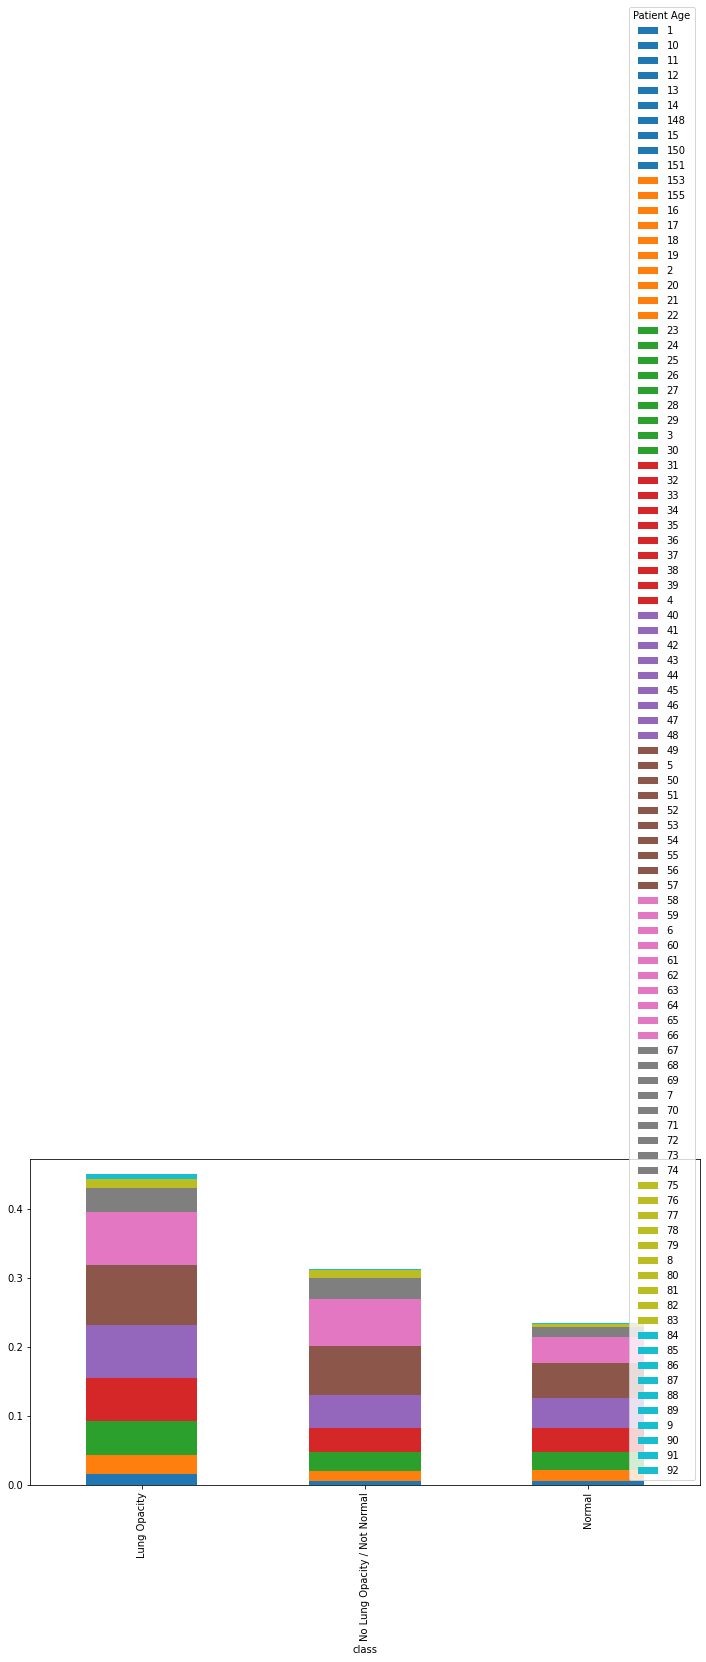

41


In [ ]:
cross_tab = pd.crosstab(index=df_data['class'],
                        columns=df_data['Patient Age'],normalize=True)
cross_tab.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(12, 6))

plt.show()

#The age range 21-68 years seem to be most susceptible to pneumonia 

print(len(df_data[pd.to_numeric(df_data['Patient Age'])>=90]))
#41 records are with age >90 which is outlier and can be removed


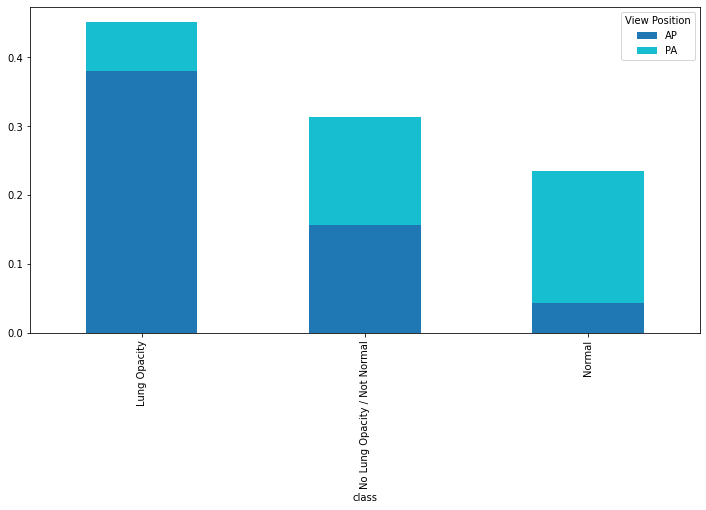

In [ ]:
cross_tab = pd.crosstab(index=df_data['class'],
                        columns=df_data['View Position'],normalize=True)
cross_tab.plot(kind='bar', 
                    stacked=True, 
                    colormap='tab10', 
                    figsize=(12, 6))
plt.show()
#AP orientation seem to account for ~90% of pneumonia cases

#Data Observations
#1. There are no duplicate patient ids in dycom data
#2. There are duplicate patient ids in class info data with identical class data which can be removed
#3. There are duplicate patient ids in label data, however, the bounding box values are different indicating different set of x-day data for same patient hence cannot be considered as duplicate
#4. Data for patient with age > 100 are present which seems not correct and can be removed  
#5. There are no entries where target =1 and bounding box is not present. Vice versa, there are no entries where target = 0 and bounding box is present

In [ ]:
df_dataDF = df_data[df_data.duplicated(['patientId','Patient Sex','Patient Age','Body Part Examined','View Position','x','y',
                                        'width','height','Target','class'])]

print('Duplicate Record Count: ', len(df_dataDF))

df_dataDF1 = df_data.drop_duplicates(['patientId','Patient Sex','Patient Age','Body Part Examined','View Position','x','y',
                                        'width','height','Target','class'],keep = 'first') 
df_dataDF1.sort_values(by=['patientId'])

#Duplicates removed

Duplicate Record Count:  7402


,Pixel Data,Patient Name,patientId,Patient Sex,Patient Age,Body Part Examined,View Position,x,y,width,height,Target,class
36476,"[[83, 39, 21, 10, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3...","(0, 0, 0, 4, c, f, a, b, -, 1, 4, f, d, -, 4, ...",0004cfab-14fd-4e49-80ba-63a80b6bddd6,F,51,CHEST,PA,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
36477,"[[0, 0, 0, 0, 2, 13, 13, 15, 15, 14, 14, 14, 1...","(0, 0, 0, 9, 2, 4, c, f, -, 0, f, 8, d, -, 4, ...",000924cf-0f8d-42bd-9158-1af53881a557,F,19,CHEST,AP,NaN,NaN,NaN,NaN,0,Normal
36480,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","(0, 0, 0, d, b, 6, 9, 6, -, c, f, 5, 4, -, 4, ...",000db696-cf54-4385-b10b-6b16fbb3f985,F,25,CHEST,AP,660.0,375.0,146.0,402.0,1,Lung Opacity
36478,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","(0, 0, 0, d, b, 6, 9, 6, -, c, f, 5, 4, -, 4, ...",000db696-cf54-4385-b10b-6b16fbb3f985,F,25,CHEST,AP,316.0,318.0,170.0,478.0,1,Lung Opacity
36484,"[[17, 18, 18, 18, 19, 19, 20, 20, 20, 20, 19, ...","(0, 0, 0, f, e, 3, 5, a, -, 2, 6, 4, 9, -, 4, ...",000fe35a-2649-43d4-b027-e67796d412e0,M,40,CHEST,AP,83.0,227.0,296.0,438.0,1,Lung Opacity
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213,"[[6, 4, 5, 5, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5,...","(f, f, f, b, 2, 3, 9, 5, -, 8, e, d, d, -, 4, ...",fffb2395-8edd-4954-8a89-ffe2fd329be3,M,46,CHEST,AP,177.0,285.0,225.0,529.0,1,Lung Opacity
1217,"[[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...","(f, f, f, b, a, 0, 5, a, -, 1, 6, 3, 5, -, 4, ...",fffba05a-1635-4545-9bbd-57ad4cfe8d27,M,31,CHEST,PA,NaN,NaN,NaN,NaN,0,Normal
1218,"[[0, 0, 1, 34, 22, 25, 41, 68, 45, 36, 36, 43,...","(f, f, f, c, 9, 5, b, 5, -, 6, 0, 5, b, -, 4, ...",fffc95b5-605b-4226-80ab-62caec682b22,F,30,CHEST,AP,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1219,"[[45, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","(f, f, f, c, f, f, 1, 1, -, d, 0, 1, 8, -, 4, ...",fffcff11-d018-4414-971a-a7cefa327795,M,47,CHEST,PA,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal


In [ ]:
#Reset index of dataframe as some deletions have been done
#Prepare training data with 70% pneumonia and 30% non pneumonia cases
import random
df_dataDF1.reset_index(inplace=True)
n = int(len(df_dataDF1)/8)
pneumonia_idx = df_dataDF1[df_dataDF1['Target']==1.0].index.to_list()
npneumonia_idx = df_dataDF1[df_dataDF1['Target']==0.0].index.to_list()

idx1 = random.choices(pneumonia_idx, k=int(n*.7)+1)
idx2 = random.choices(npneumonia_idx,k = int(n*.3))

idx = np.concatenate((idx1,idx2))


In [ ]:
print(len(idx),n)

3778 3778


In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

#df_data1 = df_dataDF1[df_data['Target']==1]
masks = np.zeros((n, IMAGE_HEIGHT, IMAGE_WIDTH))
masks_box = np.zeros((n, 4))
masks_x1 = np.zeros((n))
masks_x2 = np.zeros((n))
masks_y1 = np.zeros((n))
masks_y2 = np.zeros((n))
pneumonia_class = np.zeros((n))
#patientlist = [''] * n
patient_ids = []
X = np.zeros((n,IMAGE_HEIGHT, IMAGE_WIDTH,3))
#idx = np.random.choice(len(df_dataDF1), size=n)
cnt = 0
for index in idx:
  
  pneumonia_class[cnt] = df_dataDF1.iloc[index].at['Target']  
  patient_ids.append(df_dataDF1.iloc[index].at['patientId'])
  img = df_dataDF1.iloc[index].at['Pixel Data']
  img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  X[cnt] = preprocess_input(np.array(img, dtype=np.float32))
  # Loop through the face co-ordinates and create mask out of it.
  #print(index)

  if pd.isna(df_dataDF1.iloc[index].at['x']):  
    x1 = 0
    masks_box[cnt, 0] = x1
    
    x2 = 0
    masks_box[cnt, 2] = 0
      
    y1 = 0  
    masks_box[cnt, 1] = y1
    
    y2 = 0
    masks_box[cnt, 3] = 0
    
  else:
    x1 = int(df_dataDF1.iloc[index].at['x']*IMAGE_WIDTH/1024)
    masks_box[cnt, 0] = x1
    
    x2 = int((df_dataDF1.iloc[index].at['x'] + df_dataDF1.iloc[index].at['width'])*IMAGE_WIDTH/1024)
    masks_box[cnt, 2] = df_dataDF1.iloc[index].at['width']*IMAGE_WIDTH/1024
    
    y1 = int(df_dataDF1.iloc[index].at['y']*IMAGE_HEIGHT/1024)  
    masks_box[cnt, 1] = y1

    y2 = int((df_dataDF1.iloc[index].at['y'] + df_dataDF1.iloc[index].at['height'])*IMAGE_HEIGHT/1024)
    masks_box[cnt, 3] = df_dataDF1.iloc[index].at['height']*IMAGE_HEIGHT/1024
    
  

  # set all pixels within the mask co-ordinates to 1.
  masks[cnt][y1:y2, x1:x2] = 1
    
  masks_x1[cnt] = x1
  masks_y1[cnt] = y1
  masks_x2[cnt] = x2
  masks_y2[cnt] = y2
  cnt = cnt + 1
    

print(f"### Shape of X is '{X.shape}' and the shape of mask is '{masks.shape}' ")

### Shape of X is '(3778, 224, 224, 3)' and the shape of mask is '(3778, 224, 224)' 


In [ ]:

idx_arr = np.where(pneumonia_class==1)
n = 5
idx1 = np.random.choice(len(idx_arr[0]), size=n)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


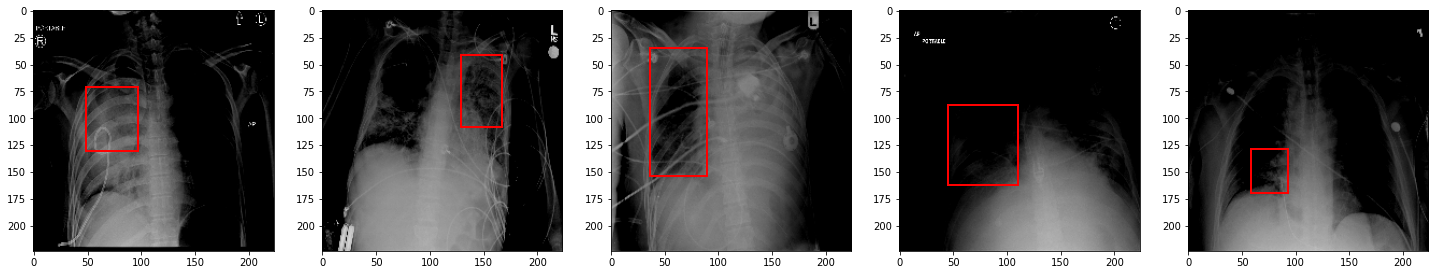

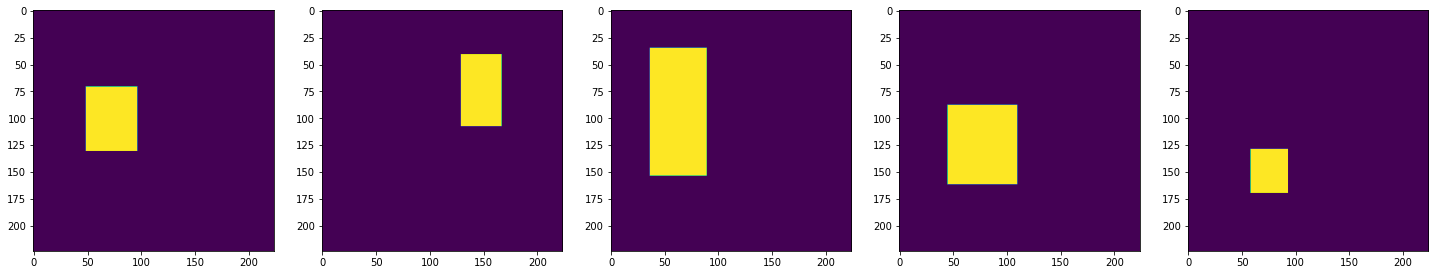

In [ ]:
fig = plt.figure(figsize=(25, 25))


count = 1
for i in idx1:
  
  ax = fig.add_subplot(1, 5, count)
  

  imgplot = plt.imshow(X[idx_arr[0][i]])
  rect = patches.Rectangle((masks_x1[idx_arr[0][i]],masks_y1[idx_arr[0][i]]), masks_x2[idx_arr[0][i]] - masks_x1[idx_arr[0][i]], 
                           masks_y2[idx_arr[0][i]] - masks_y1[idx_arr[0][i]], linewidth=2, 
                           edgecolor='r', facecolor='none')
    
  # Add the patch to the Axes
  ax.add_patch(rect)
  
  count = count + 1

fig = plt.figure(figsize=(25, 25))

count = 1
for i in idx1:
  a = fig.add_subplot(1, 5, count)
  imgplot = plt.imshow(masks[idx_arr[0][i]])
  count = count + 1




In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, Reshape
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from PIL import Image
from numpy import asarray

In [ ]:
#Split into train and test for object classification using pixel data and class data 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(np.asarray(patient_ids),pneumonia_class, test_size=0.2,stratify=pneumonia_class)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.10,stratify=y_test)

print('Shape of training data: ',X_train.shape)
print('Shape of testing data: ',X_test.shape)
print('Shape of validation data: ',X_val.shape)


Shape of training data:  (3022,)
Shape of testing data:  (680,)
Shape of validation data:  (76,)


In [ ]:
#Get pixel data

X_train_pd = []
X_test_pd = []
X_val_pd = []

for xpid in X_train:
    
    X_train_pd.append(X[np.where(np.asarray(patient_ids)==xpid)[0][0]])
    
for xpid in X_test:

    X_test_pd.append(X[np.where(np.asarray(patient_ids)==xpid)[0][0]])
    
for xpid in X_val:

    X_val_pd.append(X[np.where(np.asarray(patient_ids)==xpid)[0][0]])

In [ ]:
y_train_m = []
y_test_m = []
y_val_m = []

for xpid in X_train:
    
    y_train_m.append(masks_box[np.where(np.asarray(patient_ids)==xpid)[0][0]])
    
for xpid in X_test:
    y_test_m.append(masks_box[np.where(np.asarray(patient_ids)==xpid)[0][0]])

for xpid in X_val:
    y_val_m.append(masks_box[np.where(np.asarray(patient_ids)==xpid)[0][0]])


In [ ]:
X_train_pd = np.asarray(X_train_pd)
y_train_m = np.asarray(y_train_m)
X_test_pd = np.asarray(X_test_pd)
y_test_m = np.asarray(y_test_m)
X_val_pd = np.asarray(X_val_pd)
y_val_m = np.asarray(y_val_m)


In [ ]:
#Scale the data

X_test_pd_bk = X_test_pd
#X_train_pd = X_train_pd/255
#X_test_pd = X_test_pd/255
#X_val_pd = X_val_pd/255


In [ ]:
print("Proportion of Pneumonia cases in training set: ",int(round(len(y_train[y_train==1.0])/y_train.shape[0],2)*100),'%')
print("Proportion of Pneumonia cases in testing set: ",int(round(len(y_test[y_test==1.0])/y_test.shape[0],2)*100),'%')
print("Proportion of Pneumonia cases in validation set: ",int(round(len(y_val[y_val==1.0])/y_val.shape[0],2)*100),'%')


Proportion of Pneumonia cases in training set:  70 %
Proportion of Pneumonia cases in testing set:  70 %
Proportion of Pneumonia cases in validation set:  70 %


In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Reshape, Dense, Flatten, Dropout, AveragePooling2D, AveragePooling2D, MaxPooling2D,GlobalAveragePooling2D

#Classification Model
vgg_model = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top = False,
     input_shape = (224,224,3)
)

for layer in vgg_model.layers:
    layer.trainable=False
    
x = vgg_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs=vgg_model.input, outputs=predictions)


# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)



80150528/80134624 [==============================] - 1s 0us/step


In [ ]:

# Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
history = model.fit(X_train_pd, y_train,epochs=10, 
                    validation_data=(X_val_pd,y_val),
                     steps_per_epoch=75,
                    callbacks=[early_stopping,lr],
                    batch_size=32)

Epoch 1/10
75/75 [==============================] - 96s 1s/step - loss: 0.5403 - accuracy: 0.7358 - val_loss: 0.5621 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 2/10
75/75 [==============================] - 99s 1s/step - loss: 0.4761 - accuracy: 0.7813 - val_loss: 0.5628 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 3/10
75/75 [==============================] - 97s 1s/step - loss: 0.4675 - accuracy: 0.7914 - val_loss: 0.5656 - val_accuracy: 0.7632 - lr: 0.0010
Epoch 4/10
75/75 [==============================] - 96s 1s/step - loss: 0.4283 - accuracy: 0.8132 - val_loss: 0.5443 - val_accuracy: 0.7632 - lr: 0.0010
Epoch 5/10
75/75 [==============================] - 92s 1s/step - loss: 0.4336 - accuracy: 0.8046 - val_loss: 0.5400 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 6/10
75/75 [==============================] - 90s 1s/step - loss: 0.4161 - accuracy: 0.8140 - val_loss: 0.5340 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 7/10
75/75 [==============================] - 91s 1s/step - loss: 0.4265 - a

In [ ]:
# Test data
score = model.evaluate(X_test_pd,y_test)

print("Test Loss: ", score[0])
print("Test Accuracy: ", score[1])

22/22 [==============================] - 25s 1s/step - loss: 0.4603 - accuracy: 0.8015
Test Loss:  0.4602620601654053
Test Accuracy:  0.8014705777168274


In [ ]:
def bpredict(x,y,xmodel,x_img):
    
    y_pred = xmodel.predict(np.array([x]))
    x_pred = 0
    if y_pred >0.5:
      x_pred=1
    
    plt.imshow(x_img)
    print("Actual: ",y,"Predicted: ",x_pred)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual:  1.0 Predicted:  1


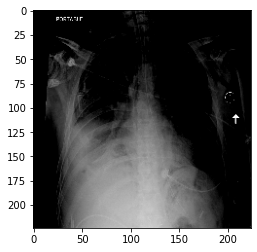

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual:  1.0 Predicted:  1


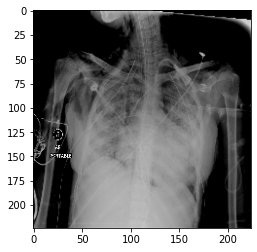

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual:  1.0 Predicted:  1


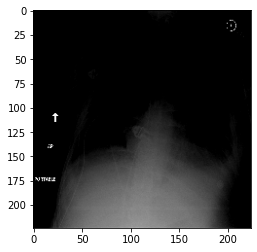

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual:  0.0 Predicted:  0


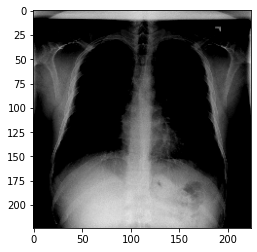

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual:  1.0 Predicted:  1


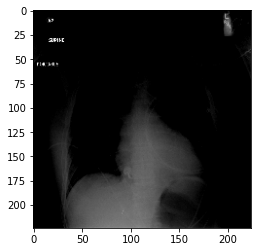

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual:  1.0 Predicted:  1


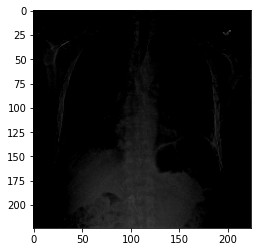

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual:  1.0 Predicted:  1


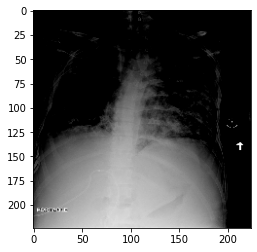

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual:  0.0 Predicted:  0


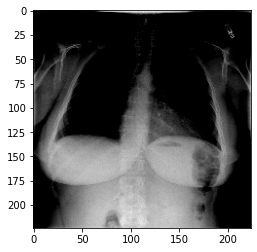

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual:  0.0 Predicted:  0


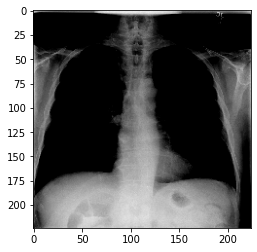

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual:  1.0 Predicted:  1


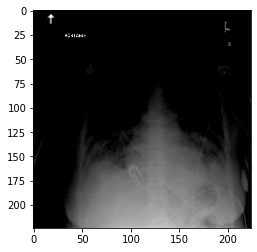

In [ ]:
idx = np.random.choice(len(X_test), size=10)
for x in idx:
  bpredict(X_test_pd[x],y_test[x],model,X_test_pd_bk[x])


In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test_pd)
count = 0
y_pred1 = []
for item in y_pred:
  val = 1
  if item < .5:
    val = 0
  y_pred1.append(val)


print(classification_report(y_test, y_pred1, target_names=['Pneumonia', 'Non Pneumonia']))

               precision    recall  f1-score   support

    Pneumonia       0.65      0.72      0.68       204
Non Pneumonia       0.87      0.84      0.86       476

     accuracy                           0.80       680
    macro avg       0.76      0.78      0.77       680
 weighted avg       0.81      0.80      0.80       680



In [ ]:
#Classification using resnet
resnet_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    include_top = False,
    input_shape = (224,224,3)
)

for layer in resnet_model.layers:
    layer.trainable=False
    
x = resnet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
# output layer
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model2 = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

# to avoid overfitting
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=6)

# Compiling the model
model2.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
# to avoid overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=8)

94683136/94668760 [==============================] - 0s 0us/step


In [ ]:
history = model2.fit(X_train_pd,y_train,epochs=10, 
                    validation_data=(X_val_pd,y_val),
                     steps_per_epoch=75,
                    batch_size=32)

Epoch 1/10
75/75 [==============================] - 60s 764ms/step - loss: 0.4614 - accuracy: 0.8017 - val_loss: 0.4553 - val_accuracy: 0.8026
Epoch 2/10
75/75 [==============================] - 55s 738ms/step - loss: 0.3736 - accuracy: 0.8497 - val_loss: 0.4523 - val_accuracy: 0.8026
Epoch 3/10
75/75 [==============================] - 56s 743ms/step - loss: 0.3438 - accuracy: 0.8518 - val_loss: 0.4583 - val_accuracy: 0.8289
Epoch 4/10
75/75 [==============================] - 57s 758ms/step - loss: 0.3172 - accuracy: 0.8690 - val_loss: 0.4590 - val_accuracy: 0.8289
Epoch 5/10
75/75 [==============================] - 57s 764ms/step - loss: 0.3025 - accuracy: 0.8788 - val_loss: 0.4430 - val_accuracy: 0.8421
Epoch 6/10
75/75 [==============================] - 56s 753ms/step - loss: 0.2499 - accuracy: 0.8984 - val_loss: 0.4857 - val_accuracy: 0.8421
Epoch 7/10
75/75 [==============================] - 58s 769ms/step - loss: 0.2567 - accuracy: 0.8984 - val_loss: 0.5460 - val_accuracy: 0.7895

In [ ]:
# Evaluating the model on train and test
score = model2.evaluate(X_train_pd,y_train)

print("Train Loss: ", score[0])
print("Train Accuracy: ", score[1])

score = model2.evaluate(X_test_pd,y_test)
print("\nTest loss: ", score[0])
print("Test Accuracy: ", score[1])

95/95 [==============================] - 38s 403ms/step - loss: 0.1332 - accuracy: 0.9762
Train Loss:  0.13316790759563446
Train Accuracy:  0.9761747121810913
22/22 [==============================] - 8s 365ms/step - loss: 0.4716 - accuracy: 0.8103

Test loss:  0.47162744402885437
Test Accuracy:  0.8102940917015076


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual:  0.0 Predicted:  0


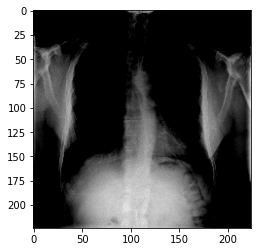

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual:  1.0 Predicted:  1


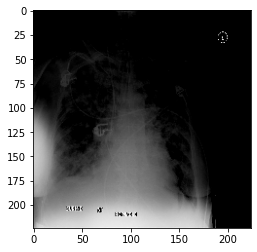

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual:  1.0 Predicted:  1


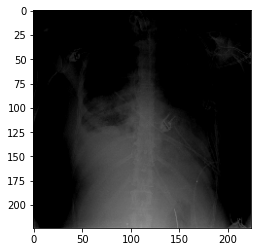

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual:  1.0 Predicted:  1


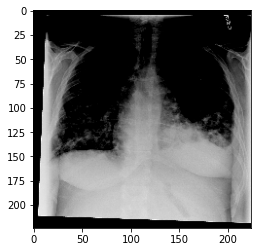

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual:  1.0 Predicted:  1


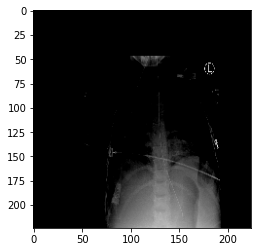

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual:  1.0 Predicted:  1


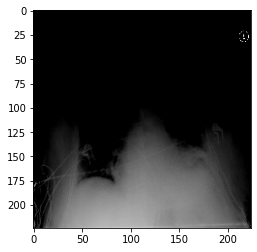

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual:  1.0 Predicted:  1


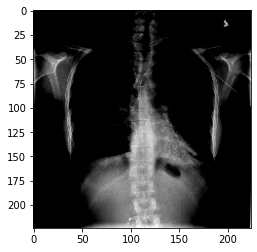

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual:  1.0 Predicted:  1


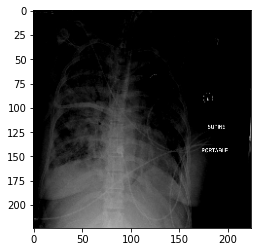

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual:  1.0 Predicted:  1


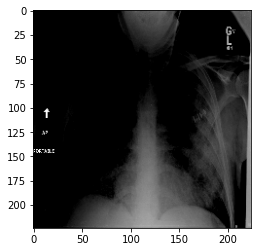

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual:  1.0 Predicted:  1


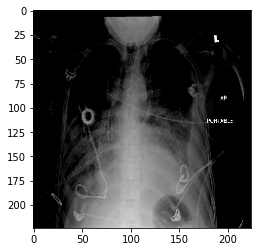

In [ ]:
idx = np.random.choice(len(X_test), size=10)
for x in idx:
  bpredict(X_test_pd[x],y_test[x],model2,X_test_pd_bk[x])


In [ ]:
from sklearn.metrics import classification_report
y_pred = model2.predict(X_test_pd)
count = 0
for item in y_pred:
  y_pred1[count]= 1
  if item < .5:
    y_pred1[count]= 0 
  count = count + 1


print(classification_report(y_test, y_pred1, target_names=['Pneumonia', 'Non Pneumonia']))

               precision    recall  f1-score   support

    Pneumonia       0.69      0.66      0.68       204
Non Pneumonia       0.86      0.87      0.87       476

     accuracy                           0.81       680
    macro avg       0.78      0.77      0.77       680
 weighted avg       0.81      0.81      0.81       680

